# AraBERTv2

In [2]:
# ============================================================================
# GPU VERIFICATION 
# ============================================================================
import torch
print("="*50)
print("GPU CHECK")
print("="*50)
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("WARNING: No GPU detected!")
    print("Go to Settings → Accelerator → Select 'GPU T4 x2'")
print("="*50)

GPU CHECK
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla P100-PCIE-16GB
CUDA version: 12.4


In [3]:
# FIX PROTOBUF COMPATIBILITY ISSUES
# ============================================================================
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import warnings
warnings.filterwarnings('ignore')

In [4]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    cohen_kappa_score, 
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


E0000 00:00:1763400832.356852      62 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763400832.422447      62 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
MODEL_NAME = "aubmindlab/bert-base-arabertv2"

# KAGGLE PATHS - Update this based on your dataset name
# Option 1: If you uploaded as a Kaggle dataset
path = "/kaggle/input/bayyin1/bayyin_dataset.csv"

# Option 2: If you uploaded directly to the notebook
# path = "/kaggle/input/bayyin_dataset.csv"

# Output directories (Kaggle's working directory)
OUTPUT_DIR_WORD = "/kaggle/working/runs/ARABERT_Word"
OUTPUT_DIR_D3TOK = "/kaggle/working/runs/ARABERT_D3Tok"
OUTPUT_DIR_LEX = "/kaggle/working/runs/ARABERT_Lex"
OUTPUT_DIR_D3LEX = "/kaggle/working/runs/ARABERT_D3Lex"

SAVE_DIR_WORD = "/kaggle/working/Arabertv2_Word"
SAVE_DIR_D3TOK = "/kaggle/working/Arabertv2_D3Tok"
SAVE_DIR_LEX = "/kaggle/working/Arabertv2_Lex"
SAVE_DIR_D3LEX = "/kaggle/working/Arabertv2_D3Lex"


In [6]:
# Training parameters
TEXT_COL = "Word"
LABEL_COL = "Readability_Level"
LEVELS = [1, 2, 3, 4, 5, 6]
LR = 5e-5
BATCH = 64
EPOCHS = 6
MAX_LEN = 128
SEED = 42
SOFT_BETA = 2.0

## Data Preparation

In [7]:
print("\nLoading dataset...")
dataset = load_dataset("csv", data_files={"train": path}, split="train")
print(f"Dataset columns: {dataset.column_names}")
print(f"Dataset size: {len(dataset)}")

# 70/20/10 split
train_test = dataset.train_test_split(test_size=0.3, seed=SEED)
test_valid = train_test["test"].train_test_split(test_size=1/3, seed=SEED)
splits = DatasetDict({
    "train": train_test["train"],
    "test": test_valid["train"],
    "validation": test_valid["test"],
})

print(f"Train: {len(splits['train'])}, Test: {len(splits['test'])}, Val: {len(splits['validation'])}")

# ============================================================================
# LABEL MAPPING & TOKENIZATION
# ============================================================================
level2id = {lvl: i for i, lvl in enumerate(LEVELS)}
id2level = {i: lvl for lvl, i in level2id.items()}

def map_labels(ds):
    return ds.map(lambda ex: {"labels": level2id[int(ex[LABEL_COL])]})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=MAX_LEN)



Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Dataset columns: ['ID', 'Sentence', 'Word_Count', 'Word', 'Lex', 'D3Tok', 'D3Lex', 'Readability_Level', 'Document', 'Source', 'Book', 'Author', 'Domain', 'Text_Class', 'Dataset_Source']
Dataset size: 46410
Train: 32487, Test: 9282, Val: 4641


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Model Training

In [8]:
# METRICS
# ============================================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    qwk = cohen_kappa_score(labels, preds, weights="quadratic")
    return {"accuracy": acc, "macro_f1": macro_f1, "qwk": qwk}


In [9]:
# ============================================================================
# CUSTOM TRAINER WITH SOFT LABELS
# ============================================================================
class SoftLabelsLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        K = logits.shape[-1]
        
        indices = torch.arange(K).float().to(logits.device)
        labels_float = labels.float().unsqueeze(1)
        diff = indices - labels_float
        squared_diff_normalized = (diff / SOFT_BETA) ** 2
        soft_targets = torch.exp(-0.5 * squared_diff_normalized)
        soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)
        
        log_softmax_logits = F.log_softmax(logits, dim=-1)
        loss_fct = nn.KLDivLoss(reduction='batchmean')
        loss = loss_fct(log_softmax_logits, soft_targets)
        
        return (loss, outputs) if return_outputs else loss

In [10]:
# EVALUATION FUNCTION
# ============================================================================
def eval_and_report(ds, name, trainer_obj):
    out = trainer_obj.predict(ds)
    preds = out.predictions.argmax(-1)
    print(f"\n{'='*60}")
    print(f"{name} Metrics")
    print('='*60)
    print(out.metrics)
    y_true = ds["labels"]
    target_names = [f"L{lvl}" for lvl in LEVELS]
    print("\nPer-class F1:")
    print(classification_report(y_true, preds, target_names=target_names, digits=4))

def plot_confusion_matrix_normalized(ds, trainer_obj, normalize='true', cmap='Blues'):
    preds_output = trainer_obj.predict(ds)
    y_true = ds["labels"]
    y_pred = preds_output.predictions.argmax(-1)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"L{lvl}" for lvl in LEVELS])
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(cmap=cmap, values_format=".2f", ax=ax, colorbar=True)
    plt.title(f"Normalized Confusion Matrix ({normalize})")
    plt.show()


In [11]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================
def train_model(text_col, output_dir, save_dir, model_name="Model"):
    print(f"\n{'#'*60}")
    print(f"# TRAINING MODEL: {model_name}")
    print(f"# Text Column: {text_col}")
    print(f"{'#'*60}\n")
    
    # Prepare datasets
    def tokenize_fn_custom(batch):
        return tokenizer(batch[text_col], truncation=True, padding="max_length", max_length=MAX_LEN)
    
    train_ds = map_labels(splits["train"]).map(tokenize_fn_custom, batched=True)
    val_ds = map_labels(splits["validation"]).map(tokenize_fn_custom, batched=True)
    test_ds = map_labels(splits["test"]).map(tokenize_fn_custom, batched=True)
    
    cols = ["input_ids", "attention_mask", "labels"]
    train_ds.set_format(type="torch", columns=cols)
    val_ds.set_format(type="torch", columns=cols)
    test_ds.set_format(type="torch", columns=cols)
    
    # Initialize model
    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LEVELS))
    
    # Training arguments
    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        warmup_ratio=0.1,
        load_best_model_at_end=True,
        metric_for_best_model="qwk",
        greater_is_better=True,
        seed=SEED,
        report_to="none",
        save_total_limit=3,
        save_safetensors=False,
        fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    )
    
    # Initialize trainer
    trainer = SoftLabelsLossTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

     # Train
    print(f"Starting Training for AraBERTv2 with SOFT (beta={SOFT_BETA}) for {EPOCHS} epochs...")
    trainer.train()
    
    # Save model
    print(f"\nSaving fine-tuned model to: {save_dir}")
    trainer.model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print("Model and tokenizer saved successfully!")
    
    # Evaluate
    print("\nEvaluating on Test Set...")
    eval_and_report(test_ds, f"Test (AraBERTv2 + SOFT - {model_name})", trainer)
    plot_confusion_matrix_normalized(test_ds, trainer)
    
    return trainer, test_ds

In [12]:
# ============================================================================
# RESULTS SUMMARY FUNCTION
# ============================================================================
def print_summary(results):
    """Print a comparison summary of all models"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY - ALL MODELS")
    print("="*80)
    print(f"{'Model':<15} {'Accuracy':<12} {'Macro F1':<12} {'QWK':<12}")
    print("-"*80)
    
    for model_name, metrics in results.items():
        acc = metrics.get('eval_accuracy', 0)
        f1 = metrics.get('eval_macro_f1', 0)
        qwk = metrics.get('eval_qwk', 0)
        print(f"{model_name:<15} {acc:<12.4f} {f1:<12.4f} {qwk:<12.4f}")
    
    print("="*80)
    
    # Find best model for each metric
    best_acc = max(results.items(), key=lambda x: x[1].get('eval_accuracy', 0))
    best_f1 = max(results.items(), key=lambda x: x[1].get('eval_macro_f1', 0))
    best_qwk = max(results.items(), key=lambda x: x[1].get('eval_qwk', 0))
    
    print(f"\nBest Accuracy: {best_acc[0]} ({best_acc[1].get('eval_accuracy', 0):.4f})")
    print(f"Best Macro F1: {best_f1[0]} ({best_f1[1].get('eval_macro_f1', 0):.4f})")
    print(f"Best QWK: {best_qwk[0]} ({best_qwk[1].get('eval_qwk', 0):.4f})")
    print("="*80)

STARTING TRAINING PIPELINE FOR 4 MODELS - AraBERTv2

############################################################
# TRAINING MODEL: Word
# Text Column: Word
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: aubmindlab/bert-base-arabertv2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for AraBERTv2 with SOFT (beta=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.083100,0.057990,0.450980,0.450257,0.773274
2,0.053000,0.053189,0.503124,0.512006,0.805390
3,0.039800,0.049699,0.574661,0.576963,0.828477
4,0.028700,0.052108,0.588235,0.583348,0.826097
5,0.021000,0.054221,0.606119,0.603138,0.831688
6,0.017000,0.053789,0.599440,0.598089,0.832250



Saving fine-tuned model to: /kaggle/working/Arabertv2_Word
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (AraBERTv2 + SOFT - Word) Metrics
{'test_loss': 0.051663801074028015, 'test_accuracy': 0.6000861883214824, 'test_macro_f1': 0.5992504742366237, 'test_qwk': 0.8383317065975775, 'test_runtime': 32.6417, 'test_samples_per_second': 284.36, 'test_steps_per_second': 4.473}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.7319    0.7677    0.7494      1550
          L2     0.6058    0.6664    0.6347      1529
          L3     0.4988    0.5373    0.5173      1556
          L4     0.4019    0.3808    0.3911      1523
          L5     0.5800    0.5237    0.5504      1585
          L6     0.7830    0.7245    0.7526      1539

    accuracy                         0.6001      9282
   macro avg     0.6002    0.6001    0.5993      9282
weighted avg     0.6004    0.6001    0.5994      9282



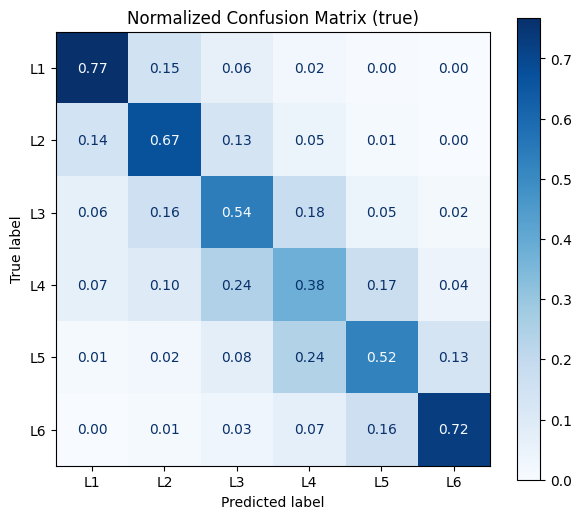

In [14]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    results = {}
    print("STARTING TRAINING PIPELINE FOR 4 MODELS - AraBERTv2")

    # Train Word
    trainer_word, test_ds_word = train_model("Word", OUTPUT_DIR_WORD, SAVE_DIR_WORD, "Word")
    results["Word"] = trainer_word.evaluate(test_ds_word)


In [15]:
!rm -rf /kaggle/working/runs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



############################################################
# TRAINING MODEL: D3Tok
# Text Column: D3Tok
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: aubmindlab/bert-base-arabertv2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for AraBERTv2 with SOFT (beta=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.072600,0.043735,0.578970,0.585687,0.847946
2,0.037500,0.038038,0.612368,0.616166,0.865582
3,0.025200,0.037705,0.655462,0.657845,0.875463
4,0.017500,0.039084,0.672700,0.669341,0.876619
5,0.012700,0.040782,0.663004,0.660411,0.874447
6,0.010100,0.039688,0.666451,0.666141,0.876913



Saving fine-tuned model to: /kaggle/working/Arabertv2_D3Tok
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (AraBERTv2 + SOFT - D3Tok) Metrics
{'test_loss': 0.03902425616979599, 'test_accuracy': 0.660848954966602, 'test_macro_f1': 0.6606630357373214, 'test_qwk': 0.8799596940805513, 'test_runtime': 32.4867, 'test_samples_per_second': 285.717, 'test_steps_per_second': 4.494}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.7738    0.7858    0.7798      1550
          L2     0.6587    0.7031    0.6802      1529
          L3     0.5350    0.6048    0.5677      1556
          L4     0.4521    0.4123    0.4313      1523
          L5     0.6446    0.6019    0.6225      1585
          L6     0.9102    0.8564    0.8825      1539

    accuracy                         0.6608      9282
   macro avg     0.6624    0.6607    0.6607      9282
weighted avg     0.6626    0.6608    0.6608      9282



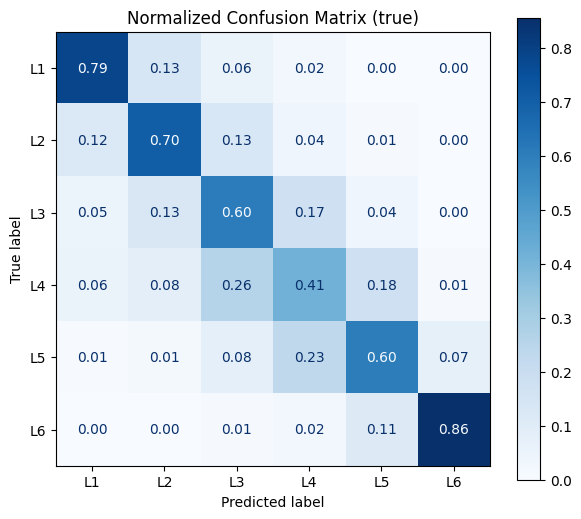

In [16]:

    # Train D3Tok
    trainer_d3tok, test_ds_d3tok = train_model("D3Tok", OUTPUT_DIR_D3TOK, SAVE_DIR_D3TOK, "D3Tok")
    results["D3Tok"] = trainer_d3tok.evaluate(test_ds_d3tok)





############################################################
# TRAINING MODEL: Lex
# Text Column: Lex
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: aubmindlab/bert-base-arabertv2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for AraBERTv2 with SOFT (beta=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.078200,0.051596,0.451627,0.428455,0.791162
2,0.045300,0.048209,0.550959,0.555527,0.829139
3,0.032400,0.045132,0.561948,0.562037,0.842755
4,0.022700,0.047464,0.597716,0.596264,0.844704
5,0.017000,0.049766,0.593191,0.591438,0.842207
6,0.013900,0.048890,0.599009,0.598495,0.845549



Saving fine-tuned model to: /kaggle/working/Arabertv2_Lex
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (AraBERTv2 + SOFT - Lex) Metrics
{'test_loss': 0.04819976165890694, 'test_accuracy': 0.590282266752855, 'test_macro_f1': 0.5902161256995658, 'test_qwk': 0.848969012264438, 'test_runtime': 32.4138, 'test_samples_per_second': 286.359, 'test_steps_per_second': 4.504}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.6696    0.7271    0.6972      1550
          L2     0.5483    0.5572    0.5527      1529
          L3     0.5142    0.5829    0.5464      1556
          L4     0.4124    0.3677    0.3888      1523
          L5     0.5696    0.5760    0.5728      1585
          L6     0.8485    0.7277    0.7835      1539

    accuracy                         0.5903      9282
   macro avg     0.5937    0.5898    0.5902      9282
weighted avg     0.5939    0.5903    0.5906      9282



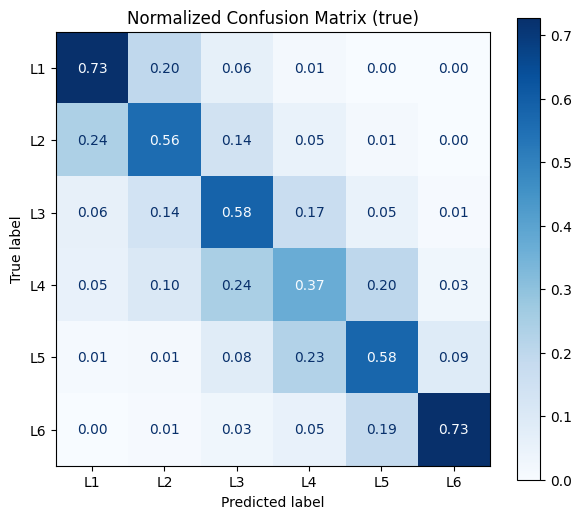

In [17]:
    # Train Lex
    trainer_lex, test_ds_lex = train_model("Lex", OUTPUT_DIR_LEX, SAVE_DIR_LEX, "Lex")
    results["Lex"] = trainer_lex.evaluate(test_ds_lex)



In [18]:
!rm -rf /kaggle/working/runs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



############################################################
# TRAINING MODEL: D3Lex
# Text Column: D3Lex
############################################################



Map:   0%|          | 0/32487 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

Map:   0%|          | 0/9282 [00:00<?, ? examples/s]

Loading model: aubmindlab/bert-base-arabertv2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training for AraBERTv2 with SOFT (beta=2.0) for 6 epochs...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Qwk
1,0.083800,0.053687,0.497522,0.493538,0.797205
2,0.046400,0.044949,0.558069,0.556234,0.833611
3,0.032300,0.043617,0.613445,0.616253,0.854724
4,0.022800,0.043205,0.634131,0.633537,0.859086
5,0.016500,0.045930,0.638225,0.637952,0.855588
6,0.013300,0.045230,0.638009,0.637573,0.857829



Saving fine-tuned model to: /kaggle/working/Arabertv2_D3Lex
Model and tokenizer saved successfully!

Evaluating on Test Set...



Test (AraBERTv2 + SOFT - D3Lex) Metrics
{'test_loss': 0.043285664170980453, 'test_accuracy': 0.6175393234216764, 'test_macro_f1': 0.6144135845094746, 'test_qwk': 0.8568874673444324, 'test_runtime': 32.4269, 'test_samples_per_second': 286.243, 'test_steps_per_second': 4.502}

Per-class F1:
              precision    recall  f1-score   support

          L1     0.7488    0.7845    0.7662      1550
          L2     0.6291    0.6599    0.6441      1529
          L3     0.5588    0.4949    0.5249      1556
          L4     0.4130    0.3349    0.3698      1523
          L5     0.5232    0.7123    0.6033      1585
          L6     0.8558    0.7135    0.7782      1539

    accuracy                         0.6175      9282
   macro avg     0.6214    0.6167    0.6144      9282
weighted avg     0.6213    0.6175    0.6148      9282



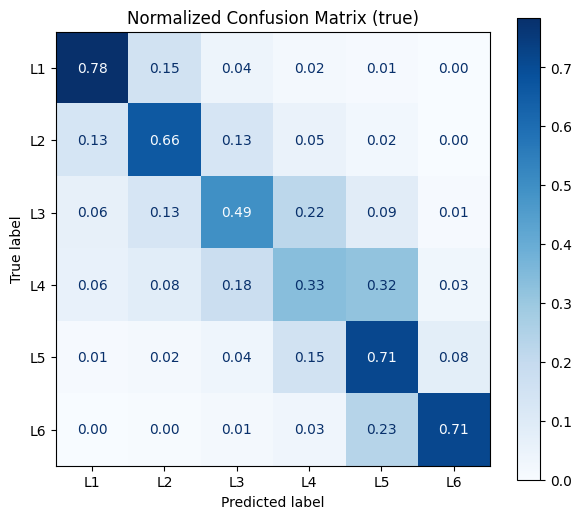

In [19]:
    # Train D3Lex
    trainer_d3lex, test_ds_d3lex = train_model("D3Lex", OUTPUT_DIR_D3LEX, SAVE_DIR_D3LEX, "D3Lex")
    results["D3Lex"] = trainer_d3lex.evaluate(test_ds_d3lex)
    

In [20]:
    print_summary(results)
    print("\n" + "="*80)
    print("ALL TRAINING COMPLETE!")
    print("="*80)
    print(f"\nModels saved to:\n  - {SAVE_DIR_WORD}\n  - {SAVE_DIR_D3TOK}\n  - {SAVE_DIR_LEX}\n  - {SAVE_DIR_D3LEX}")
    print("="*80)


FINAL RESULTS SUMMARY - ALL MODELS
Model           Accuracy     Macro F1     QWK         
--------------------------------------------------------------------------------
Word            0.6001       0.5993       0.8383      
D3Tok           0.6608       0.6607       0.8800      
Lex             0.5903       0.5902       0.8490      
D3Lex           0.6175       0.6144       0.8569      

Best Accuracy: D3Tok (0.6608)
Best Macro F1: D3Tok (0.6607)
Best QWK: D3Tok (0.8800)

ALL TRAINING COMPLETE!

Models saved to:
  - /kaggle/working/Arabertv2_Word
  - /kaggle/working/Arabertv2_D3Tok
  - /kaggle/working/Arabertv2_Lex
  - /kaggle/working/Arabertv2_D3Lex
